# Relación Entre Viajes En Bicicleta y el Clima

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
trips = pd.read_csv('data/trip.csv', low_memory=False)
weather = pd.read_csv('data/weather.csv', low_memory=False)
#Se convierte los dates a datetime64[ns].
trips['start_date'] = pd.to_datetime(trips['start_date'])
weather['date'] = pd.to_datetime(weather['date'])

In [3]:
#Se agrega una nueva columna date que coincide con weather.
trips['date'] = trips['start_date'].apply(lambda x: x.date())
#Se convierte date a datetime64[ns].
trips['date'] = pd.to_datetime(trips['date'])

In [4]:
#Se convierte zip_code a string en weather para coincidir con trips.
#NOTA: No se convierte zip_code de trips a int64 por un extraño error en to_numeric.
weather['zip_code'] = weather['zip_code'].astype(str)

In [5]:
#Formula para convertir F a C.
def f_to_c(f_temp):
    return round((f_temp - 32) / 1.8, 2)

In [6]:
#Se crean columnas con las temperaturas en C.
weather['max_temperature_c'] = weather['max_temperature_f'].map(f_to_c)
weather['mean_temperature_c'] = weather['mean_temperature_f'].map(f_to_c)
weather['min_temperature_c'] = weather['min_temperature_f'].map(f_to_c)

In [7]:
#Se combinan los Dataframes.
joined = trips.merge(weather, left_on=['date', 'zip_code'], right_on=['date', 'zip_code'])

## 1) Viajes y Temperatura

En esta serie de plots se analizará si hay una correlación entre los viajes en bicicleta y la temperatura.

Como los registros del clima estan en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climaticas para decidir si realizar un viaje o no. 

### 1.A) Histograma del Promedio de Temperatura

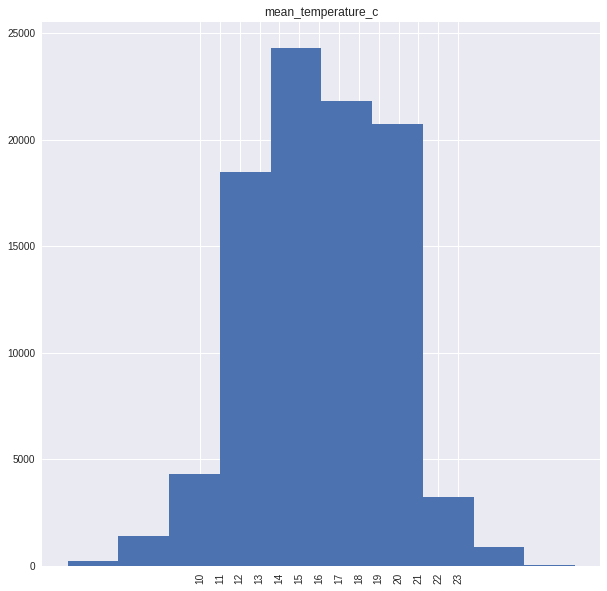

In [10]:
joined.hist(column='mean_temperature_c', grid=True, figsize=(10,10), xrot=90);
plt.xticks(range(10,24,1));

En este histograma se puede apreciar que la mayor cantidad de los viajes se realizan cuando la temperatura promedio esta entre 12°C y 21°C.  
Si bien puede parecer que la temperatura es algo baja, hay que tener en cuenta que esto es un promedio de la temperatura de todo el día y como San Francisco es una ciudad costera la temperatura suele bajar bastante sobre la noche.

### 1.B) Histograma de la Temperatura Maxima

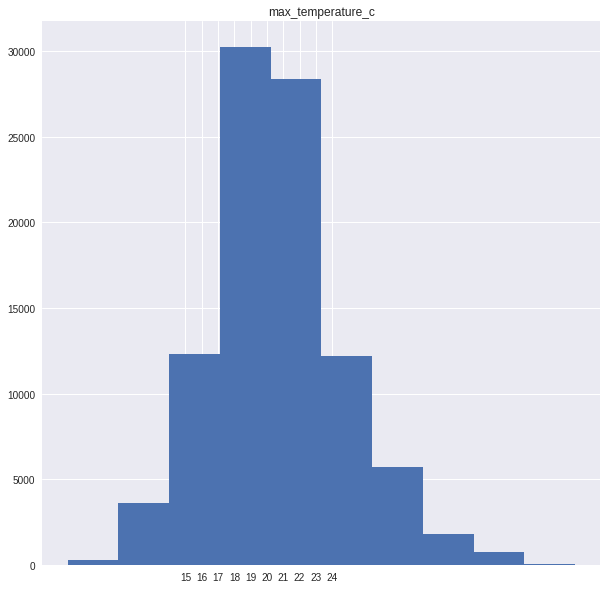

In [14]:
joined.hist(column='max_temperature_c', grid=True, figsize=(10,10));
plt.xticks(range(15,25,1));

De este histograma se puede obtener que la mayoria de los viajes se realizan cuando la temperatura maxima esta entre 18°C y 23°C.

Si se toman en cuenta los dos histogramas en conjunto, se puede apreciar que la mayoría de las personas buscan temperaturas templadas a la hora de realizar los viajes.  
No es necesario analizar la temperatura mínima, ya que como se dijo antes, la temperatura suele bajar mucho sobre la noche y daría resultados engañosos.

### 1.C) Dias con mayor uso simultaneo de Bicicletas y la Temperatura

In [15]:
#Funciones para clasificar.
def f_st(row):
    if row['event'] == 'start_date':
        val = 1
    else:
        val = 0
    return val

def f_en(row):
    if row['event'] == 'end_date':
        val = 1
    else:
        val = 0
    return val

In [16]:
trips_aux = trips[['id', 'start_date', 'end_date', 'zip_code']]
trips_melt = pd.melt(trips_aux, id_vars=['id','zip_code'], value_vars=['start_date', 'end_date'], var_name='event', value_name='time')
trips_melt['time'] = pd.to_datetime(trips_melt['time'])

In [17]:
#Se obtiene la cantidad de bicicletas en uso al mismo tiempo.
trips_ord = trips_melt.sort_values('time', ascending=True) 
trips_ord['start_counter'] = trips_ord.apply(f_st, axis=1)
trips_ord['end_counter'] = trips_ord.apply(f_en, axis=1)
trips_ord['start'] = trips_ord['start_counter'].cumsum()
trips_ord['end'] = trips_ord['end_counter'].cumsum()
trips_ord = trips_ord[['id', 'zip_code', 'time', 'start', 'end']]
trips_ord['in_use'] = trips_ord['start'] - trips_ord['end']
trips_ord = trips_ord.sort_values('in_use', ascending=False)

In [18]:
#Se eliminan los horarios para coincidir con weather.csv.
trips_ord['time'] = trips_ord['time'].apply(lambda x: x.date())
#Se convierte time a datetime64[ns].
trips_ord['time'] = pd.to_datetime(trips_ord['time'])

In [19]:
#Se combinan los Dataframes.
joined_simul = trips_ord.merge(weather, left_on=['time', 'zip_code'], right_on=['date', 'zip_code'])

In [20]:
#Solo hay que quedarse con el maximo de bicicletas simultaneas para ese dia.
joined_max_simul = joined_simul.drop_duplicates(subset=['time'], keep='first')

In [21]:
#Nos quedamos con los 10 valores maximos y las columnas que interesan.
joined_max_simul_bar = joined_max_simul[:10]
joined_max_simul_bar = joined_max_simul_bar[['time', 'mean_temperature_c', 'max_temperature_c']]
joined_max_simul_bar.set_index('time', inplace=True)

En el siguiente gráfico de barras se pueden aprecian los 10 días (de los cuales hay datos de temperatura) con mayor uso simultaneo de bicicletas(ordenados de forma descendente), junto con su temperatura promedio y temperatura máxima. La locación tomada para el clima de cada día, es donde se produce su respectivo pico máximo de bicicletas en uso.

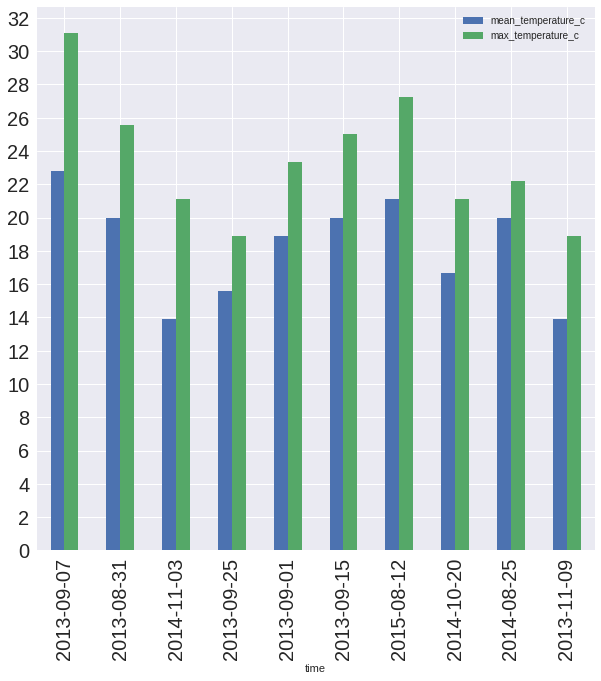

In [27]:
bar = joined_max_simul_bar.plot.bar(figsize=(10,10), fontsize=20);
#Elimina el 00:00:00 del plot.
bar.set_xticklabels(joined_max_simul_bar.index.format());
plt.yticks(range(0,33,2));

Primero es interesante notar que si bien el día con mayor uso simultaneo es también el día con mayor temperatura máxima, unos 31°C, los días restantes no tienen temperaturas máximas tan elevadas.  
El segundo punto importante a notar es que la mayoría de estos días tienen temperaturas templadas, es decir, sus temperaturas promedio varían entre 14°C y 23°C mientras que sus temperaturas máximas están entre 19 y 25°C.  
Por ultimo, es evidente que si bien la cantidad de bicicletas en uso simultáneamente decrece a lo largo del gráfico de barras, las temperaturas se mantienen siempre dentro de un mismo rango.

### 1.D) Conclusión de Viajes y Temperatura

Usando los plots anteriores se puede concluir que **la mayor cantidad de viajes se realizan cuando la temperatura es templada**, es decir, cuando esta **alrededor de los 25°C**.
Para describir este fenómeno hay que tener en cuenta los motivos por los cuales se podría realizar un viaje, para simplificar se tomaran dos casos:
1. En el caso de que se quiera realizar un viaje por la necesidad de trasladarse, la temperatura no afecta mucho, excepto en casos de muy bajas o muy altas temperaturas.
2. El caso en el cual se quiere realizar un viaje por placer es el que interesa, ya que es aquí cuando la temperatura juega un rol importante. Con temperaturas templadas las personas estarán mas predispuestas a realizar viajes en bicicleta, como muestran los plots obtenidos. 

Por ultimo, es importante notar que las mejores temperaturas se suelen presentar sobre la tarde, ya que es cuando comienza a bajar el sol, por eso no seria extraño que la mayor cantidad de los viajes se realicen en horarios de la tarde.